# Capstone Project -  (Week 2) Finding a location
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Discussion](#discussion)
* [Conclusion](#conclusion)

## Introduction <a name="introduction"></a>


In this project we will try to find an optimal location to rent a studio apartment in New York City. Specifically, this report will be addressed to **those students who need to rent a room to access their classes at Columbia University in New York City**.

As there are many studio apartments in New York City, we will try to detect places considering 3 factors; crime rate, rent cost and finally, proximity to places of preference. We would also prefer locations as close as possible to the university, assuming the first three conditions are met.

We will use data science to generate some more promising neighborhoods based on this criterion. The advantages of each area will be clearly expressed so that those interested can choose the best possible final location.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:

* Number of crimes committed in each county of New York City
* Average rental cost of a studio apartment
* Proximity to places of preference

We decided to use regularly spaced grid of locations, centered around city center, to define our neighborhoods.

Following data sources will be needed to extract/generate the required information:

* Number of total crimes per county, for which the database of **Open Data** will be used "NYPD Complaint Data Current (Year To Date)" 'https://data.cityofnewyork.us/api/views/5uac-w243/rows.csv'

* The exact middle asking rent among all rental listings available on **StreetEasy** at any point during the month/quarter/year. In general, median values are more accurate than average values, which may be skewed by price outliers (a few rentals that are extremely expensive or extremely inexpensive).
https://streeteasy-market-data-download.s3.amazonaws.com/rentals/Studio/medianAskingRent_Studio.zip

* Number of preference places and their type and location in every neighborhood will be obtained using **Foursquare API**

## Methodology <a name="methodology"></a>

## 1. Crimes in NYC

### 1.1. Downloading and Prepping Data

In [1]:
import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library

Let's download and import the data on police department incidents using *pandas* `read_csv()` method

In [2]:
#Download the dataset and read it into a *pandas* dataframe:
df_crimesny = pd.read_csv('https://data.cityofnewyork.us/api/views/5uac-w243/rows.csv')
print('Dataset downloaded and read into a pandas dataframe!')

Dataset downloaded and read into a pandas dataframe!


Let's take a look at the first five items in our dataset

In [3]:
df_crimesny.head()

CMPLNT_NUM  ADDR_PCT_CD    BORO_NM CMPLNT_FR_DT CMPLNT_FR_TM CMPLNT_TO_DT  \
0   314773184           48      BRONX   12/31/2019     18:00:00          NaN   
1   289837961           25  MANHATTAN   12/30/2019     20:30:00   12/31/2019   
2   535744284           77   BROOKLYN   12/24/2019     16:55:00   12/24/2019   
3   895678119           52      BRONX   12/30/2019     19:32:00          NaN   
4   299841674           18  MANHATTAN   12/30/2019     15:30:00   12/30/2019   

  CMPLNT_TO_TM CRM_ATPT_CPTD_CD HADEVELOPT  HOUSING_PSA  ...  SUSP_SEX  \
0          NaN        COMPLETED        NaN          NaN  ...         U   
1     10:00:00        COMPLETED        NaN          NaN  ...       NaN   
2     17:00:00        COMPLETED        NaN          NaN  ...         M   
3          NaN        COMPLETED        NaN          NaN  ...         F   
4     16:50:00        COMPLETED        NaN          NaN  ...       NaN   

  TRANSIT_DISTRICT  VIC_AGE_GROUP        VIC_RACE VIC_SEX X_COORD_CD  \
0              NaN          45-64  WHITE HISPANIC       F    1016990   
1              NaN          25-44  WHITE HISPANIC       F     999296   
2              NaN          18-24           WHITE       M    1001068   
3              NaN        UNKNOWN         UNKNOWN       D    1009690   
4              NaN          25-44  WHITE HISPANIC       M     985766   

  Y_COORD_CD   Latitude  Longitude                                   Lat_Lon  
0     244612  40.838026 -73.881681  (40.838026269000075, -73.88168118799997)  
1     230862  40.800334 -73.945657  (40.800334261000046, -73.94565697199994)  
2     183317  40.669832 -73.939376   (40.66983179600004, -73.93937555099996)  
3     257590  40.873671 -73.908014   (40.87367103500002, -73.90801364899994)  
4     216503  40.760935 -73.994529   (40.76093528000007, -73.99452906599998)  

[5 rows x 35 columns]

So each row consists of 35 features:
> 1. **CMPLNT_NUM**: Randomly generated persistent ID for each complaint 
> 2. **ADDR_PCT_CD**: The precinct in which the incident occurred
> 3. **BORO_NM**: The name of the borough in which the incident occurred
> 4. **CMPLNT_FR_DT**: Exact date of occurrence for the reported event
> 5. **CMPLNT_FR_TM**: Exact time of occurrence for the reported event
> 6. **CMPLNT_TO_DT**: Ending date of occurrence for the reported event, if exact time of occurrence is unknown
> 7. **CMPLNT_TO_TM**: Ending time of occurrence for the reported event, if exact time of occurrence is unknown
> 8. **CRM_ATPT_CPTD_CD**: Indicator of whether crime was successfully completed or attempted, but failed or was interrupted prematurely
> 9. **HADEVELOPT**: Name of NYCHA housing development of occurrence, if applicable
> 10. **HOUSING_PSA**: Development Level Code
> 11. **JURISDICTION_CODE**: Jurisdiction responsible for incident
> 12. **JURIS_DESC**: Description of the jurisdiction code
> 13. **KY_CD**: Three digit offense classification code
> 14. **LAW_CAT_CD**: Level of offense: felony, misdemeanor, violation 
> 15. **LOC_OF_OCCUR_DESC**: Specific location of occurrence in or around the premises
> 16. **OFNS_DESC**: Description of offense corresponding with key code
> 17. **PARKS_NM**: Name of NYC park, playground or greenspace of occurrence, if applicable 
> 18. **PATROL_BORO**: The name of the patrol borough in which the incident occurred
> 19. **PD_CD**: Three digit internal classification code
> 20. **PD_DESC**: Description of internal classification corresponding with PD code  
> 21. **PREM_TYP_DESC**: Specific description of premises; grocery store, residence, street, etc.
> 22. **RPT_DT**: Date event was reported to police 
> 23. **STATION_NAME**: Transit station name
> 24. **SUSP_AGE_GROUP**: Suspect’s Age Group
> 25. **SUSP_RACE**: Suspect’s Race Description
> 26. **SUSP_SEX**: Suspect’s Sex Description
> 27. **TRANSIT_DISTRICT**: Transit district in which the offense occurred.
> 28. **VIC_AGE_GROUP**: Victim’s Age Group
> 29. **VIC_RACE**: Victim’s Race Description
> 30. **VIC_SEX**: Victim’s Sex Description
> 31. **X_COORD_CD**: X-coordinate for New York State Plane Coordinate System
> 32. **Y_COORD_CD**: Y-coordinate for New York State Plane Coordinate System
> 33. **Latitude**: Midblock Latitude coordinate for Global Coordinate System
> 34. **Longitude**: Midblock Longitude coordinate for Global Coordinate System
> 35. **Lat_Lon**: (Latitude,Longitude)

Let's find out how many entries there are in our dataset.

In [4]:
df_crimesny.shape

(461711, 35)

Clean up data. We will make some modifications to the original dataset to make it easier to create our visualizations.

In [5]:
# clean up the dataset to remove unnecessary columns  
df_crimesny.drop(['ADDR_PCT_CD', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM',
       'CMPLNT_TO_DT', 'CMPLNT_TO_TM', 'CRM_ATPT_CPTD_CD', 'HADEVELOPT',
       'HOUSING_PSA', 'JURISDICTION_CODE', 'JURIS_DESC', 'KY_CD', 'LAW_CAT_CD',
       'LOC_OF_OCCUR_DESC', 'OFNS_DESC', 'PARKS_NM', 'PATROL_BORO', 'PD_CD',
       'PD_DESC', 'PREM_TYP_DESC', 'RPT_DT', 'STATION_NAME', 'SUSP_AGE_GROUP',
       'SUSP_RACE', 'SUSP_SEX', 'TRANSIT_DISTRICT', 'VIC_AGE_GROUP',
       'VIC_RACE', 'VIC_SEX','X_COORD_CD','Y_COORD_CD','Lat_Lon'], axis=1, inplace=True)
df_crimesny.head()

CMPLNT_NUM    BORO_NM   Latitude  Longitude
0   314773184      BRONX  40.838026 -73.881681
1   289837961  MANHATTAN  40.800334 -73.945657
2   535744284   BROOKLYN  40.669832 -73.939376
3   895678119      BRONX  40.873671 -73.908014
4   299841674  MANHATTAN  40.760935 -73.994529

In [6]:
# let's rename the columns so that they make sense
df_crimesny.rename(columns={'CMPLNT_NUM':'Id', 'BORO_NM':'Borough'}, inplace=True)

# for sake of consistency, let's also make all column labels of type string
df_crimesny.columns = list(map(str, df_crimesny.columns))

df_crimesny.head()

Id    Borough   Latitude  Longitude
0  314773184      BRONX  40.838026 -73.881681
1  289837961  MANHATTAN  40.800334 -73.945657
2  535744284   BROOKLYN  40.669832 -73.939376
3  895678119      BRONX  40.873671 -73.908014
4  299841674  MANHATTAN  40.760935 -73.994529

In [7]:
# checking if there are any null values

df_crimesny.isnull().sum()

Id             0
Borough      326
Latitude       0
Longitude      0
dtype: int64

In [8]:
#Let's drop NaN values in Borough

df_crimesny=df_crimesny.dropna()
df_crimesny.shape

(461385, 4)

Let's check how many crimes were returned for each borough

In [9]:
df_crimesny.groupby('Borough').count()

Id  Latitude  Longitude
Borough                                   
BRONX          100994    100994     100994
BROOKLYN       132445    132445     132445
MANHATTAN      116352    116352     116352
QUEENS          92575     92575      92575
STATEN ISLAND   19019     19019      19019

### 1.2. Visualization

#### Let's install **Folium**

In [10]:
!conda install -c conda-forge folium=0.5.0 --yes
import folium

print('Folium installed and imported!')

Solving environment: done

# All requested packages already installed.

Folium installed and imported!


So the dataframe consists of 461385 crimes, which took place in the year 2017. Let's just work with the first 100 incidents in this dataset

Now, let's visualize where these crimes took place in the city of New York. We will use the default style and we will initialize the zoom level to 12. The latitude of New York City, NY, USA is 40.730610, and the longitude is -73.93524. 

In [11]:
# get the first 100 crimes in the df_crimesny dataframe
limit = 100
df_crimesnyc = df_crimesny.iloc[0:limit, :]
df_crimesnyc.shape

(100, 4)

In [12]:
# New York latitude and longitude values
latitude = 40.730610
longitude = -73.93524

Now let's superimpose the locations of the crimes onto the map

In [13]:
# create map and display it
nycity_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# loop through the 100 crimes and add each to the map
for lat, lng, label in zip(df_crimesnyc.Latitude, df_crimesnyc.Longitude, df_crimesnyc.Borough):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5, # define how big you want the circle markers to be
        color='yellow',
        fill=True,
        popup=label,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(nycity_map)

# show map
nycity_map

## 2. Apartment rental prices

### 2.1. Downloading and Prepping Data

In [14]:
# The code was removed by Watson Studio for sharing.

areaName    Borough   areaType  2010-01  2010-02  2010-03  \
0         All Downtown  Manhattan  submarket   2350.0   2300.0   2200.0   
1          All Midtown  Manhattan  submarket   2000.0   1995.0   1995.0   
2  All Upper East Side  Manhattan  submarket   1750.0   1750.0   1750.0   
3  All Upper Manhattan  Manhattan  submarket   1175.0   1150.0   1150.0   
4  All Upper West Side  Manhattan  submarket   1800.0   1800.0   1795.0   

   2010-04  2010-05  2010-06  2010-07  ...  2019-03  2019-04  2019-05  \
0   2263.0   2300.0   2300.0   2290.0  ...   2895.0   2900.0   2950.0   
1   2000.0   2000.0   2000.0   2050.0  ...   2650.0   2650.0   2650.0   
2   1780.0   1800.0   1750.0   1750.0  ...   2150.0   2150.0   2175.0   
3   1150.0   1173.0   1195.0   1250.0  ...   1700.0   1750.0   1795.0   
4   1800.0   1895.0   1895.0   1800.0  ...   2400.0   2350.0   2325.0   

   2019-06  2019-07  2019-08  2019-09  2019-10  2019-11  2019-12  
0   2950.0   2950.0   2900.0   2950.0   3000.0   3000.0   3000.0  
1   2699.0   2700.0   2700.0   2700.0   2700.0   2700.0   2750.0  
2   2150.0   2108.0   2150.0   2150.0   2150.0   2198.0   2250.0  
3   1800.0   1800.0   1800.0   1800.0   1780.0   1750.0   1750.0  
4   2300.0   2313.0   2300.0   2350.0   2395.0   2463.0   2492.0  

[5 rows x 123 columns]

Clean up data. We will make some modifications to the original dataset to make it easier to create our visualizations. We will visualize year 2019.

In [15]:
df_data_1.columns
# clean up the dataset to remove unnecessary columns 
df_data_1.drop(['areaName','areaType','2010-01', '2010-02', '2010-03',
       '2010-04', '2010-05', '2010-06', '2010-07','2010-08', '2010-09', '2010-10',
       '2010-11', '2010-12', '2011-01', '2011-02','2011-03', '2011-04', '2011-05',
       '2011-06', '2011-07', '2011-08', '2011-09','2011-10',
       '2011-11', '2011-12', '2012-01', '2012-02','2012-03', '2012-04', '2012-05',
       '2012-06', '2012-07', '2012-08', '2012-09','2012-10',
       '2012-11', '2012-12', '2013-01', '2013-02','2013-03', '2013-04', '2013-05',
       '2013-06', '2013-07', '2013-08', '2013-09','2013-10',
       '2013-11', '2013-12', '2014-01', '2014-02','2014-03', '2014-04', '2014-05',
       '2014-06', '2014-07', '2014-08', '2014-09','2014-10',
       '2014-11', '2014-12', '2015-01', '2015-02','2015-03', '2015-04', '2015-05',
       '2015-06', '2015-07', '2015-08', '2015-09','2015-10',
       '2015-11', '2015-12', '2016-01', '2016-02','2016-03', '2016-04', '2016-05',
       '2016-06', '2016-07', '2016-08', '2016-09','2016-10',
       '2016-11', '2016-12', '2017-01', '2017-02','2017-03', '2017-04', '2017-05',
       '2017-06', '2017-07', '2017-08', '2017-09','2017-10',
       '2017-11', '2017-12', '2018-01', '2018-02','2018-03', '2018-04', '2018-05',
       '2018-06', '2018-07', '2018-08', '2018-09','2018-10',
       '2018-11', '2018-12'], axis=1, inplace=True)
df_data_1.columns


Index(['Borough', '2019-01', '2019-02', '2019-03', '2019-04', '2019-05',
       '2019-06', '2019-07', '2019-08', '2019-09', '2019-10', '2019-11',
       '2019-12'],
      dtype='object')

In [16]:
# let's rename the columns so that they make sense
df_data_1.rename(columns={'2019-01':'Jan', '2019-02':'Feb', '2019-03':'Mar',
       '2019-04':'Apr','2019-05':'May','2019-06':'Jun', '2019-07':'Jul', '2019-08':'Aug', '2019-09':'Sep',
       '2019-10':'Oct', '2019-11':'Nov', '2019-12':'Dec'}, inplace=True)
df_data_1.head()

Borough     Jan     Feb     Mar     Apr     May     Jun     Jul     Aug  \
0  Manhattan  2850.0  2900.0  2895.0  2900.0  2950.0  2950.0  2950.0  2900.0   
1  Manhattan  2650.0  2690.0  2650.0  2650.0  2650.0  2699.0  2700.0  2700.0   
2  Manhattan  2100.0  2150.0  2150.0  2150.0  2175.0  2150.0  2108.0  2150.0   
3  Manhattan  1700.0  1750.0  1700.0  1750.0  1795.0  1800.0  1800.0  1800.0   
4  Manhattan  2300.0  2350.0  2400.0  2350.0  2325.0  2300.0  2313.0  2300.0   

      Sep     Oct     Nov     Dec  
0  2950.0  3000.0  3000.0  3000.0  
1  2700.0  2700.0  2700.0  2750.0  
2  2150.0  2150.0  2198.0  2250.0  
3  1800.0  1780.0  1750.0  1750.0  
4  2350.0  2395.0  2463.0  2492.0

#Let's drop NaN values and then, add average column

In [17]:
df_data_1=df_data_1.dropna()
df_data_1.round(1).head()

Borough     Jan     Feb     Mar     Apr     May     Jun     Jul     Aug  \
0  Manhattan  2850.0  2900.0  2895.0  2900.0  2950.0  2950.0  2950.0  2900.0   
1  Manhattan  2650.0  2690.0  2650.0  2650.0  2650.0  2699.0  2700.0  2700.0   
2  Manhattan  2100.0  2150.0  2150.0  2150.0  2175.0  2150.0  2108.0  2150.0   
3  Manhattan  1700.0  1750.0  1700.0  1750.0  1795.0  1800.0  1800.0  1800.0   
4  Manhattan  2300.0  2350.0  2400.0  2350.0  2325.0  2300.0  2313.0  2300.0   

      Sep     Oct     Nov     Dec  
0  2950.0  3000.0  3000.0  3000.0  
1  2700.0  2700.0  2700.0  2750.0  
2  2150.0  2150.0  2198.0  2250.0  
3  1800.0  1780.0  1750.0  1750.0  
4  2350.0  2395.0  2463.0  2492.0

In [18]:
df_grup=df_data_1.groupby('Borough').mean()
df_grup

Jan          Feb          Mar          Apr          May  \
Borough                                                                      
Bronx      1420.500000  1500.000000  1462.500000  1436.500000  1544.000000   
Brooklyn   2046.423077  2044.846154  2064.423077  2091.038462  2155.423077   
Manhattan  2514.714286  2551.821429  2531.714286  2563.464286  2579.500000   
Queens     1681.642857  1687.571429  1692.500000  1745.357143  1747.000000   

                   Jun          Jul          Aug          Sep          Oct  \
Borough                                                                      
Bronx      1500.000000  1544.000000  1562.500000  1575.000000  1556.500000   
Brooklyn   2150.153846  2162.615385  2159.153846  2166.730769  2149.692308   
Manhattan  2600.142857  2615.321429  2599.607143  2619.178571  2649.571429   
Queens     1795.000000  1783.714286  1783.500000  1794.857143  1782.000000   

                   Nov          Dec  
Borough                              
Bronx      1550.000000  1550.000000  
Brooklyn   2121.076923  2160.423077  
Manhattan  2638.392857  2639.178571  
Queens     1768.785714  1778.500000

In [19]:
df_grup['Average'] = df_grup.mean(axis=1)
df_grup.round(1)

Jan     Feb     Mar     Apr     May     Jun     Jul     Aug  \
Borough                                                                     
Bronx      1420.5  1500.0  1462.5  1436.5  1544.0  1500.0  1544.0  1562.5   
Brooklyn   2046.4  2044.8  2064.4  2091.0  2155.4  2150.2  2162.6  2159.2   
Manhattan  2514.7  2551.8  2531.7  2563.5  2579.5  2600.1  2615.3  2599.6   
Queens     1681.6  1687.6  1692.5  1745.4  1747.0  1795.0  1783.7  1783.5   

              Sep     Oct     Nov     Dec  Average  
Borough                                             
Bronx      1575.0  1556.5  1550.0  1550.0   1516.8  
Brooklyn   2166.7  2149.7  2121.1  2160.4   2122.7  
Manhattan  2619.2  2649.6  2638.4  2639.2   2591.9  
Queens     1794.9  1782.0  1768.8  1778.5   1753.4

## Analysis <a name="analysis"></a>

According to the data corresponding to the crime rate in New York, the following results can be obtained, but first, We will modificate the dataframe.

In [20]:
order=df_crimesny.groupby('Borough').count()
order

Id  Latitude  Longitude
Borough                                   
BRONX          100994    100994     100994
BROOKLYN       132445    132445     132445
MANHATTAN      116352    116352     116352
QUEENS          92575     92575      92575
STATEN ISLAND   19019     19019      19019

In [21]:
order.columns
order.drop(['Latitude','Longitude'],axis=1, inplace=True)
order.rename(columns={'Id':'Number of crimes'},inplace=True)


In [22]:
order.sort_values(by=['Number of crimes'], inplace=True)
order

Number of crimes
Borough                        
STATEN ISLAND             19019
QUEENS                    92575
BRONX                    100994
MANHATTAN                116352
BROOKLYN                 132445

As we already knew, Staten Island presents the lowest amount of crimes, represented by 4.1%, while the largest amount is obtained by Brooklyn with 132445 crimes, represented by 28.7%, which can be seen in the following pie chart.

In [23]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print('Matplotlib version: ', mpl.__version__) # >= 2.0.0


Matplotlib version:  3.0.2


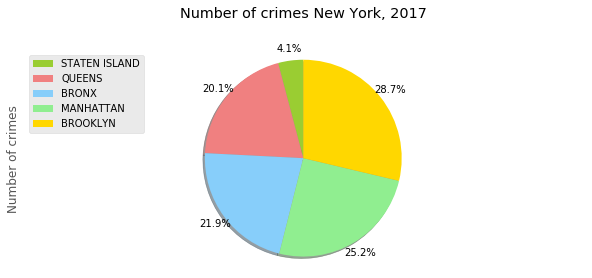

In [24]:
# autopct create %, start angle represent starting point
colors_list = ['yellowgreen', 'lightcoral', 'lightskyblue', 'lightgreen','gold']
order['Number of crimes'].plot(kind='pie',
                            figsize=(10, 4),
                            autopct='%1.1f%%', 
                            startangle=90,    
                            shadow=True,       
                            labels=None,         # turn off labels on pie chart
                            pctdistance=1.12,    # the ratio between the center of each pie slice and the start of the text generated by autopct 
                            colors=colors_list,  # add custom colors
                            )

# scale the title up by 12% to match pctdistance
plt.title('Number of crimes New York, 2017', y=1.12) 

plt.axis('equal') 

# add legend
plt.legend(labels=order.index, loc='upper left') 

plt.show()

With this in mind, let's analyze the rental cost of a studio apartment, according to the 2019 data

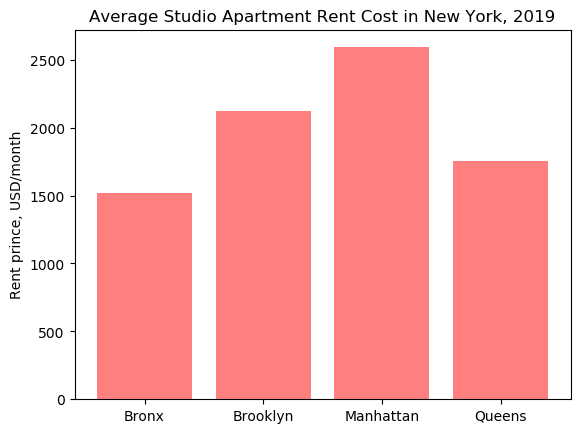

In [25]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
objects = ('Bronx', 'Brooklyn', 'Manhattan', 'Queens')
y_pos = np.arange(len(objects))
performance = [1516.8,2122.7,2591.9,1753.4]

plt.bar(y_pos, performance, align='center', alpha=0.5, color='r')
plt.xticks(y_pos, objects)
plt.ylabel('Rent prince, USD/month')
plt.title('Average Studio Apartment Rent Cost in New York, 2019')

plt.show()

Unfortunately, Staten Island is not in this list of bourghs, so even though it has the lowest crime rate, we have no way of relating the cost of living associated with the monthly rental of a studio apartment in Staten Island.


Considering the crime rate in Brooklyn, and the high costs of Manhattan, we will analyze the leisure activities offered by each alternative using the Foursquare API. Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [26]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


The files are placed on a server, so we can simply run a `wget` command and access the data. 

In [27]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [28]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

#### Transform the data into a *pandas* dataframe

In [29]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [30]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

#### Use geopy library to get the latitude and longitude values of New York City.

In [31]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


#### Create a map of New York with neighborhoods superimposed on top.

In [32]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#FFA500',
        fill=True,
        fill_color='#FFD700',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them

#### Define Foursquare Credentials and Version

In [33]:
# The code was removed by Watson Studio for sharing.

#### Explore neighborhoods in New York


In [36]:
LIMIT = 200 # limit of number of venues returned by Foursquare API

radius = 500 # define radius
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [37]:
new_york_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

#### Let's check the size of the resulting dataframe

In [38]:
print(new_york_venues.shape)
new_york_venues.head()

(10244, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
2    Wakefield              40.894705              -73.847201   
3    Wakefield              40.894705              -73.847201   
4    Wakefield              40.894705              -73.847201   

              Venue  Venue Latitude  Venue Longitude  Venue Category  
0  Lollipops Gelato       40.894123       -73.845892    Dessert Shop  
1          Rite Aid       40.896649       -73.844846        Pharmacy  
2  Carvel Ice Cream       40.890487       -73.848568  Ice Cream Shop  
3             Shell       40.894187       -73.845862     Gas Station  
4            SUBWAY       40.890468       -73.849152  Sandwich Place

Let's check how many venues were returned for each neighborhood

In [39]:
new_york_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  \
Neighborhood                                                               
Allerton                                      37                      37   
Annadale                                      10                      10   
Arden Heights                                  5                       5   
Arlington                                      5                       5   
Arrochar                                      18                      18   
Arverne                                       18                      18   
Astoria                                      100                     100   
Astoria Heights                               11                      11   
Auburndale                                    18                      18   
Bath Beach                                    50                      50   
Battery Park City                             97                      97   
Bay Ridge                                     84                      84   
Bay Terrace                                   48                      48   
Baychester                                    18                      18   
Bayside                                       69                      69   
Bayswater                                      3                       3   
Bedford Park                                  36                      36   
Bedford Stuyvesant                            26                      26   
Beechhurst                                    12                      12   
Bellaire                                      12                      12   
Belle Harbor                                  17                      17   
Bellerose                                     21                      21   
Belmont                                       99                      99   
Bensonhurst                                   31                      31   
Bergen Beach                                   7                       7   
Blissville                                    18                      18   
Bloomfield                                     5                       5   
Boerum Hill                                   90                      90   
Borough Park                                  25                      25   
Breezy Point                                   4                       4   
Briarwood                                     12                      12   
Brighton Beach                                45                      45   
Broad Channel                                  5                       5   
Broadway Junction                             15                      15   
Bronxdale                                     12                      12   
Brooklyn Heights                             100                     100   
Brookville                                     1                       1   
Brownsville                                   21                      21   
Bulls Head                                    47                      47   
Bushwick                                      73                      73   
Butler Manor                                   6                       6   
Cambria Heights                               16                      16   
Canarsie                                       7                       7   
Carnegie Hill                                100                     100   
Carroll Gardens                              100                     100   
Castle Hill                                    9                       9   
Castleton Corners                             14                      14   
Central Harlem                                46                      46   
Charleston                                    30                      30   
Chelsea                                      104                     104   
Chinatown                                    100                     100   

#### Let's find out how many unique categories can be curated from all the returned venues

In [40]:
print('There are {} uniques categories.'.format(len(new_york_venues['Venue Category'].unique())))

There are 427 uniques categories.


#### Analyze Each Neighborhood

In [41]:
# one hot encoding
ny_onehot = pd.get_dummies(new_york_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ny_onehot['Neighborhood'] = new_york_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[fixed_columns]

ny_onehot.head(10)

Yoga Studio  Accessories Store  Adult Boutique  Afghan Restaurant  \
0            0                  0               0                  0   
1            0                  0               0                  0   
2            0                  0               0                  0   
3            0                  0               0                  0   
4            0                  0               0                  0   
5            0                  0               0                  0   
6            0                  0               0                  0   
7            0                  0               0                  0   
8            0                  0               0                  0   
9            0                  0               0                  0   

   African Restaurant  Airport Terminal  American Restaurant  Antique Shop  \
0                   0                 0                    0             0   
1                   0                 0                    0             0   
2                   0                 0                    0             0   
3                   0                 0                    0             0   
4                   0                 0                    0             0   
5                   0                 0                    0             0   
6                   0                 0                    0             0   
7                   0                 0                    0             0   
8                   0                 0                    0             0   
9                   0                 0                    0             0   

   Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0       0                 0                       0            0           0   
1       0                 0                       0            0           0   
2       0                 0                       0            0           0   
3       0                 0                       0            0           0   
4       0                 0                       0            0           0   
5       0                 0                       0            0           0   
6       0                 0                       0            0           0   
7       0                 0                       0            0           0   
8       0                 0                       0            0           0   
9       0                 0                       0            0           0   

   Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0                    0                     0                 0   
1                    0                     0                 0   
2                    0                     0                 0   
3                    0                     0                 0   
4                    0                     0                 0   
5                    0                     0                 0   
6                    0                     0                 0   
7                    0                     0                 0   
8                    0                     0                 0   
9                    0                     0                 0   

   Athletics & Sports  Auditorium  Australian Restaurant  Austrian Restaurant  \
0                   0           0                      0                    0   
1                   0           0                      0                    0   
2                   0           0                      0                    0   
3                   0           0                      0                    0   
4                   0           0                      0                    0   
5                   0           0                      0                    0   
6                   0           0                      0                    0   
7                   0           0                      0                    0   
8             

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [42]:
nyc_grouped = ny_onehot.groupby('Neighborhood').mean().reset_index()
nyc_grouped

Neighborhood  Yoga Studio  Accessories Store  \
0                     Allerton     0.000000           0.000000   
1                     Annadale     0.000000           0.000000   
2                Arden Heights     0.000000           0.000000   
3                    Arlington     0.000000           0.000000   
4                     Arrochar     0.000000           0.000000   
5                      Arverne     0.000000           0.000000   
6                      Astoria     0.000000           0.000000   
7              Astoria Heights     0.000000           0.000000   
8                   Auburndale     0.000000           0.000000   
9                   Bath Beach     0.000000           0.000000   
10           Battery Park City     0.000000           0.000000   
11                   Bay Ridge     0.000000           0.000000   
12                 Bay Terrace     0.000000           0.020833   
13                  Baychester     0.000000           0.000000   
14                     Bayside     0.014493           0.000000   
15                   Bayswater     0.000000           0.000000   
16                Bedford Park     0.000000           0.000000   
17          Bedford Stuyvesant     0.000000           0.000000   
18                  Beechhurst     0.000000           0.000000   
19                    Bellaire     0.000000           0.000000   
20                Belle Harbor     0.000000           0.000000   
21                   Bellerose     0.000000           0.000000   
22                     Belmont     0.000000           0.000000   
23                 Bensonhurst     0.000000           0.000000   
24                Bergen Beach     0.000000           0.000000   
25                  Blissville     0.000000           0.000000   
26                  Bloomfield     0.000000           0.000000   
27                 Boerum Hill     0.022222           0.000000   
28                Borough Park     0.000000           0.000000   
29                Breezy Point     0.000000           0.000000   
30                   Briarwood     0.000000           0.000000   
31              Brighton Beach     0.000000           0.000000   
32               Broad Channel     0.000000           0.000000   
33           Broadway Junction     0.000000           0.000000   
34                   Bronxdale     0.000000           0.000000   
35            Brooklyn Heights     0.050000           0.000000   
36                  Brookville     0.000000           0.000000   
37                 Brownsville     0.000000           0.000000   
38                  Bulls Head     0.000000           0.000000   
39                    Bushwick     0.000000           0.000000   
40                Butler Manor     0.000000           0.000000   
41             Cambria Heights     0.000000           0.000000   
42                    Canarsie     0.000000           0.000000   
43               Carnegie Hill     0.030000           0.000000   
44             Carroll Gardens     0.000000           0.000000   
45                 Castle Hill     0.000000           0.000000   
46           Castleton Corners     0.000000           0.000000   
47              Central Harlem     0.000000           0.000000   
48                  Charleston     0.000000           0.000000   
49                     Chelsea     0.009615           0.000000   
50                   Chinatown     0.010000           0.000000   
51                 City Island     0.000000           0.000000   
52                   City Line     0.000000           0.000000   
53                Civic Center     0.030000           0.000000   
54           Claremont Village     0.000000           0.000000   
55                Clason Point     0.000000           0.000000   
56                     Clifton     0.000000           0.000000   
57                     Clinton     0.000000           0.000000   
58                Clinton Hill     0.031579           0.000000   
59                  Co-op City     0.000000           0.05

#### Let's print each neighborhood along with the top 5 most common venues

In [43]:
num_top_venues = 5

for hood in nyc_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = nyc_grouped[nyc_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Allerton----
                venue  freq
0         Pizza Place  0.16
1       Deli / Bodega  0.08
2         Supermarket  0.08
3  Chinese Restaurant  0.05
4    Department Store  0.05


----Annadale----
         venue  freq
0  Pizza Place   0.2
1       Bakery   0.2
2        Diner   0.1
3   Sports Bar   0.1
4   Restaurant   0.1


----Arden Heights----
           venue  freq
0       Pharmacy   0.2
1  Deli / Bodega   0.2
2    Pizza Place   0.2
3    Coffee Shop   0.2
4       Bus Stop   0.2


----Arlington----
           venue  freq
0       Bus Stop   0.4
1  Deli / Bodega   0.2
2  Boat or Ferry   0.2
3  Grocery Store   0.2
4    Yoga Studio   0.0


----Arrochar----
                      venue  freq
0                  Bus Stop  0.11
1             Deli / Bodega  0.11
2        Italian Restaurant  0.11
3  Mediterranean Restaurant  0.06
4     Outdoors & Recreation  0.06


----Arverne----
             venue  freq
0        Surf Spot  0.22
1   Sandwich Place  0.11
2    Metro Station  0.11
3      Co

#### Let's put that into a *pandas* dataframe

In [62]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [72]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted2 = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted2['Neighborhood'] = nyc_grouped['Neighborhood']

for ind in np.arange(nyc_grouped.shape[0]):
    neighborhoods_venues_sorted2.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted2.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0       Allerton           Pizza Place         Deli / Bodega   
1       Annadale                Bakery           Pizza Place   
2  Arden Heights              Pharmacy         Deli / Bodega   
3      Arlington              Bus Stop         Deli / Bodega   
4       Arrochar    Italian Restaurant         Deli / Bodega   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0           Supermarket    Chinese Restaurant      Department Store   
1            Sports Bar              Pharmacy   American Restaurant   
2              Bus Stop           Coffee Shop           Pizza Place   
3         Boat or Ferry         Grocery Store         Women's Store   
4              Bus Stop     Polish Restaurant            Food Truck   

  6th Most Common Venue      7th Most Common Venue  8th Most Common Venue  \
0  Fast Food Restaurant          Martial Arts Dojo          Grocery Store   
1            Restaurant              Train Station                  Diner   
2         Women's Store                      Field          Event Service   
3           Fish Market                    Exhibit                Factory   
4            Bagel Shop  Middle Eastern Restaurant  Outdoors & Recreation   

  9th Most Common Venue 10th Most Common Venue  
0           Gas Station         Breakfast Spot  
1    English Restaurant   Ethiopian Restaurant  
2           Event Space                Exhibit  
3    Falafel Restaurant                   Farm  
4        Sandwich Place     Athletics & Sports

#### Cluster Neighborhoods


Run *k*-means to cluster the neighborhood into 10 clusters

In [73]:
# set number of clusters
kclusters = 10

nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([5, 5, 6, 0, 6, 5, 3, 5, 3, 5], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [74]:
neighborhoods_venues_sorted2.insert(0, 'Cluster_Labels', kmeans.labels_)

ny_ci_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
ny_ci_merged = ny_ci_merged.join(neighborhoods_venues_sorted2.set_index('Neighborhood'), on='Neighborhood')

ny_ci_merged.head() # check the last columns!

Borough Neighborhood   Latitude  Longitude  Cluster_Labels  \
0   Bronx    Wakefield  40.894705 -73.847201             1.0   
1   Bronx   Co-op City  40.874294 -73.829939             1.0   
2   Bronx  Eastchester  40.887556 -73.827806             1.0   
3   Bronx    Fieldston  40.895437 -73.905643             1.0   
4   Bronx    Riverdale  40.890834 -73.912585             1.0   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0            Laundromat        Sandwich Place              Pharmacy   
1           Bus Station   Fried Chicken Joint        Discount Store   
2  Caribbean Restaurant         Deli / Bodega           Bus Station   
3           Music Venue                 River           Bus Station   
4                  Park                  Bank           Bus Station   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0        Ice Cream Shop  Caribbean Restaurant           Gas Station   
1                  Park    Chinese Restaurant         Grocery Store   
2                 Diner           Pizza Place         Bowling Alley   
3                 Plaza         Women's Store   Filipino Restaurant   
4                   Gym          Home Service         Moving Target   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0          Dessert Shop            Donut Shop         Event Service   
1              Pharmacy            Bagel Shop             Gift Shop   
2    Seafood Restaurant            Donut Shop    Chinese Restaurant   
3  Ethiopian Restaurant         Event Service           Event Space   
4                 Plaza            Food Truck                  Food   

  10th Most Common Venue  
0            Event Space  
1     Salon / Barbershop  
2               Platform  
3                Exhibit  
4      Food & Drink Shop

We find that there is no data available for some neighbourhood droping that row

In [75]:
ny_ci_merged=ny_ci_merged.dropna()

In [76]:
ny_ci_merged['Cluster_Labels'] = ny_ci_merged.Cluster_Labels.astype(int)


In [77]:
# create map
map_clusters2 = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(ny_ci_merged['Latitude'], ny_ci_merged['Longitude'], ny_ci_merged['Neighborhood'], ny_ci_merged['Cluster_Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters2)
       
map_clusters2

### Examine Clusters

### Cluster 1: Bus Stop

In [87]:
ny_ci_merged.loc[ny_ci_merged['Cluster_Labels'] == 0, ny_ci_merged.columns[[1] + list(range(5, ny_ci_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
77   Manhattan Beach              Bus Stop        Ice Cream Shop   
172     Breezy Point                 Trail              Bus Stop   
198     New Brighton              Bus Stop                  Park   
202      Grymes Hill         Moving Target              Bus Stop   
204      South Beach                 Beach                  Pier   
212          Oakwood                   Bar              Bus Stop   
224        Park Hill              Bus Stop                 Hotel   
227        Arlington              Bus Stop         Deli / Bodega   
245       Bloomfield     Recreation Center              Bus Stop   
256    Randall Manor              Bus Stop                  Park   
285      Willowbrook              Bus Stop          Intersection   
286     Sandy Ground              Bus Stop          Intersection   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
77             Playground                  Café        Sandwich Place   
172                 Beach   Monument / Landmark         Women's Store   
198         Deli / Bodega          Home Service        Discount Store   
202               Dog Run         Women's Store     Fish & Chips Shop   
204         Deli / Bodega              Bus Stop    Athletics & Sports   
212                Lawyer     Fish & Chips Shop         Event Service   
224           Coffee Shop  Gym / Fitness Center    Athletics & Sports   
227         Boat or Ferry         Grocery Store         Women's Store   
245                  Park            Theme Park        Discount Store   
256            Playground         Women's Store   Filipino Restaurant   
285         Deli / Bodega           Pizza Place         Women's Store   
286                Market     Fish & Chips Shop    Athletics & Sports   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
77            Pizza Place                  Food                 Beach   
172     Fish & Chips Shop           Event Space               Exhibit   
198            Playground         Women's Store           Event Space   
202           Event Space               Exhibit               Factory   
204         Women's Store   Filipino Restaurant           Event Space   
212           Event Space               Exhibit               Factory   
224   Filipino Restaurant         Event Service           Event Space   
227           Fish Market               Exhibit               Factory   
245     Food & Drink Shop                  Food         Event Service   
256         Event Service           Event Space               Exhibit   
285   Filipino Restaurant         Event Service           Event Space   
286            Playground           Art Gallery                  Lake   

    9th Most Common Venue 10th Most Common Venue  
77                Exhibit                Factory  
172               Factory     Falafel Restaurant  
198               Exhibit                Factory  
202    Falafel Restaurant                   Farm  
204               Exhibit                Factory  
212    Falafel Restaurant                   Farm  
224               Exhibit                Factory  
227    Falafel Restaurant                   Farm  
245           Event Space             Food Truck  
256               Factory     Falafel Restaurant  
285               Exhibit                Factory  
286             Racetrack             Food Truck

### Cluster 2: Caribbean - Chinese Restaurants

In [81]:
ny_ci_merged.loc[ny_ci_merged['Cluster_Labels'] == 1, ny_ci_merged.columns[[1] + list(range(5, ny_ci_merged.shape[1]))]]

Neighborhood 1st Most Common Venue  \
0              Wakefield            Laundromat   
1             Co-op City           Bus Station   
2            Eastchester  Caribbean Restaurant   
3              Fieldston           Music Venue   
4              Riverdale                  Park   
13          Bedford Park    Chinese Restaurant   
18            West Farms           Bus Station   
25            Morrisania        Discount Store   
26             Soundview    Chinese Restaurant   
41             Olinville  Caribbean Restaurant   
43             Concourse         Grocery Store   
45              Edenwald    Chinese Restaurant   
54              Flatbush  Caribbean Restaurant   
56         East Flatbush                Bakery   
60           Brownsville            Restaurant   
72         East New York         Deli / Bodega   
73         Starrett City          Intersection   
74              Canarsie    Chinese Restaurant   
75             Flatlands              Pharmacy   
78          Coney Island      Baseball Stadium   
93   Prospect Park South  Caribbean Restaurant   
158        Fresh Meadows           Bus Station   
163               Hollis        Baseball Field   
164        South Jamaica           Bus Station   
165           St. Albans  Caribbean Restaurant   
166             Rochdale                Market   
167  Springfield Gardens            Donut Shop   
168      Cambria Heights  Caribbean Restaurant   
169             Rosedale           Bus Station   
170         Far Rockaway           Pizza Place   
183      Jamaica Estates          Intersection   
222              Wingate   Fried Chicken Joint   
223                Rugby  Caribbean Restaurant   
259       Remsen Village  Caribbean Restaurant   
260             New Lots   Fried Chicken Joint   
263        Jamaica Hills     Indian Restaurant   
267    Claremont Village    Chinese Restaurant   
268    Concourse Village    Mexican Restaurant   
282    Broadway Junction            Donut Shop   
300              Erasmus  Caribbean Restaurant   
305            Fox Hills        Sandwich Place   

               2nd Most Common Venue          3rd Most Common Venue  \
0                     Sandwich Place                       Pharmacy   
1                Fried Chicken Joint                 Discount Store   
2                      Deli / Bodega                    Bus Station   
3                              River                    Bus Station   
4                               Bank                    Bus Station   
13                             Diner                    Supermarket   
18                              Park                    Pizza Place   
25                       Pizza Place                  Grocery Store   
26                     Grocery Store                       Bus Stop   
41                       Supermarket                     Laundromat   
43                       Pizza Place                    Supermarket   
45                       Supermarket                  Grocery Store   
54                     Deli / Bodega                       Pharmacy   
56                  Department Store                 Hardware Store   
60                Chinese Restaurant                           Park   
72                       Music Venue                          Plaza   
73               American Restaurant                     Donut Shop   
74                     Deli / Bodega           Caribbean Restaurant   
75               Fried Chicken Joint           Caribbean Restaurant   
78              Caribbean Restaurant   Theme Park Ride / Attraction   
93                 Mobile Phone Shop                  Grocery Store   
158                         Pharmacy             Chinese Restaurant   
163              Fried Chicken Joint                           Park   
164                           Bakery  Vegetarian / Vegan Restaurant   
165                             Café                 Discount Store   
166  Southern / Soul Food Restaurant                           Ba

### Cluster 3: Historic Site

In [82]:
ny_ci_merged.loc[ny_ci_merged['Cluster_Labels'] == 2, ny_ci_merged.columns[[1] + list(range(5, ny_ci_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
255  Emerson Hill         Historic Site                  Food   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
255         Women's Store   Filipino Restaurant  Ethiopian Restaurant   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
255         Event Service           Event Space               Exhibit   

    9th Most Common Venue 10th Most Common Venue  
255               Factory     Falafel Restaurant

### Cluster 4: Bar

In [83]:
ny_ci_merged.loc[ny_ci_merged['Cluster_Labels'] == 3, ny_ci_merged.columns[[1] + list(range(5, ny_ci_merged.shape[1]))]]

Neighborhood      1st Most Common Venue  \
9         Williamsbridge                        Bar   
12           City Island            Harbor / Marina   
22           Port Morris                Music Venue   
46             Bay Ridge         Italian Restaurant   
49            Greenpoint                        Bar   
51        Brighton Beach         Russian Restaurant   
52        Sheepshead Bay               Dessert Shop   
58       Windsor Terrace              Deli / Bodega   
59      Prospect Heights                        Bar   
61          Williamsburg                        Bar   
62              Bushwick                        Bar   
63    Bedford Stuyvesant                Pizza Place   
64      Brooklyn Heights                Yoga Studio   
65           Cobble Hill                 Playground   
66       Carroll Gardens         Italian Restaurant   
67              Red Hook         Seafood Restaurant   
68               Gowanus         Italian Restaurant   
69           Fort Greene         Italian Restaurant   
70            Park Slope               Burger Joint   
76           Mill Island                  Locksmith   
81         Dyker Heights                      Plaza   
82       Gerritsen Beach                        Bar   
84          Clinton Hill         Italian Restaurant   
85              Sea Gate                      Beach   
86              Downtown               Burger Joint   
87           Boerum Hill                        Bar   
91          Bergen Beach            Harbor / Marina   
95     East Williamsburg                        Bar   
96            North Side                Coffee Shop   
97            South Side                        Bar   
100            Chinatown         Chinese Restaurant   
101   Washington Heights                       Café   
102               Inwood         Mexican Restaurant   
103     Hamilton Heights                Pizza Place   
104       Manhattanville              Deli / Bodega   
105       Central Harlem         African Restaurant   
106          East Harlem         Mexican Restaurant   
107      Upper East Side         Italian Restaurant   
108            Yorkville         Italian Restaurant   
109           Lenox Hill                Coffee Shop   
110     Roosevelt Island                       Park   
111      Upper West Side         Italian Restaurant   
112       Lincoln Square                    Theater   
113              Clinton                    Theater   
114              Midtown                      Hotel   
115          Murray Hill          Korean Restaurant   
116              Chelsea                Coffee Shop   
117    Greenwich Village         Italian Restaurant   
118         East Village                        Bar   
119      Lower East Side                Pizza Place   
120              Tribeca        American Restaurant   
121         Little Italy                     Bakery   
122                 Soho             Clothing Store   
123         West Village         Italian Restaurant   
124     Manhattan Valley          Indian Restaurant   
125  Morningside Heights                       Park   
126             Gramercy         Italian Restaurant   
127    Battery Park City                       Park   
128   Financial District                Coffee Shop   
129              Astoria                        Bar   
131      Jackson Heights  Latin American Restaurant   
132             Elmhurst            Thai Restaurant   
138             Flushing          Hotpot Restaurant   
139     Long Island City                Coffee Shop   
151              Bayside                        Bar   
152           Auburndale         Italian Restaurant   
153          Little Neck         Italian Restaurant   
160       Jamaica Center          Mobile Phone Shop   
173             Steinway        Rental Car Location   
175          Bay Terrace             Clothing Store   
178       Rockaway Beach                      Beach   
180          Murray Hill          Korean Restaurant 

### Cluster 5: Park

In [84]:
ny_ci_merged.loc[ny_ci_merged['Cluster_Labels'] == 4, ny_ci_merged.columns[[1] + list(range(5, ny_ci_merged.shape[1]))]]

Neighborhood 1st Most Common Venue       2nd Most Common Venue  \
27   Clason Point                  Park                    Bus Stop   
192    Somerville                  Park               Women's Store   
203     Todt Hill                  Park               Women's Store   
303     Bayswater                  Park  Construction & Landscaping   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
27          Boat or Ferry                  Pool         Grocery Store   
192    English Restaurant         Event Service           Event Space   
203    English Restaurant         Event Service           Event Space   
303            Playground         Women's Store   Filipino Restaurant   

         6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
27   South American Restaurant         Women's Store                 Field   
192                    Exhibit               Factory    Falafel Restaurant   
203                    Exhibit               Factory    Falafel Restaurant   
303              Event Service           Event Space               Exhibit   

    9th Most Common Venue 10th Most Common Venue  
27            Event Space                Exhibit  
192                  Farm         Farmers Market  
203                  Farm         Farmers Market  
303               Factory     Falafel Restaurant

### Cluster 6: Pizza

In [85]:
ny_ci_merged.loc[ny_ci_merged['Cluster_Labels'] == 5, ny_ci_merged.columns[[1] + list(range(5, ny_ci_merged.shape[1]))]]

Neighborhood      1st Most Common Venue  \
5                  Kingsbridge                Pizza Place   
6                  Marble Hill             Sandwich Place   
8                      Norwood                Pizza Place   
10                  Baychester                 Donut Shop   
11              Pelham Parkway         Italian Restaurant   
14          University Heights                     Bakery   
15              Morris Heights                   Pharmacy   
16                     Fordham       Fast Food Restaurant   
17                East Tremont                Pizza Place   
19                High  Bridge                Pizza Place   
20                     Melrose                Pizza Place   
21                  Mott Haven                     Bakery   
24                 Hunts Point                       Bank   
30                 Parkchester                Supermarket   
31          Westchester Square       Fast Food Restaurant   
32                    Van Nest                Pizza Place   
33                 Morris Park                Pizza Place   
35              Spuyten Duyvil               Tennis Court   
36             North Riverdale                Pizza Place   
37                  Pelham Bay         Italian Restaurant   
38               Schuylerville         Mexican Restaurant   
40                 Castle Hill                       Bank   
42              Pelham Gardens                   Pharmacy   
44                   Unionport                 Donut Shop   
47                 Bensonhurst         Italian Restaurant   
48                 Sunset Park  Latin American Restaurant   
50                   Gravesend                Pizza Place   
53           Manhattan Terrace                 Donut Shop   
55               Crown Heights                Pizza Place   
57                  Kensington            Thai Restaurant   
71               Cypress Hills        Fried Chicken Joint   
79                  Bath Beach                   Pharmacy   
80                Borough Park                       Bank   
88   Prospect Lefferts Gardens                     Bakery   
90                   City Line                 Donut Shop   
92                     Midwood                Pizza Place   
94                  Georgetown                       Bank   
98               Ocean Parkway                   Sake Bar   
99               Fort Hamilton                Pizza Place   
130                   Woodside              Grocery Store   
135               Forest Hills       Gym / Fitness Center   
136                Kew Gardens         Chinese Restaurant   
137              Richmond Hill  Latin American Restaurant   
140                  Sunnyside         Italian Restaurant   
141              East Elmhurst                 Donut Shop   
142                    Maspeth                      Diner   
143                  Ridgewood                       Bank   
144                   Glendale                    Brewery   
145                  Rego Park                     Bakery   
147                 Ozone Park                   Pharmacy   
149              College Point                Pizza Place   
155                  Glen Oaks                   Pharmacy   
156                  Bellerose                Pizza Place   
157          Kew Gardens Hills                       Bank   
161            Oakland Gardens          Korean Restaurant   
162             Queens Village                       Bank   
176                   Edgemere              Metro Station   
177                    Arverne                  Surf Spot   
181                Floral Park          Indian Restaurant   
182                 Holliswood                 Playground   
184            Queensboro Hill         Chinese Restaurant   
185                  Hillcrest                 Donut Shop   
187                 Lindenwood                       Bank   
191              Rockaway Park                      Beach   
196       Forest Hills Gardens             Sandwich P

### Cluster 7: Italian Restaurant

In [88]:
ny_ci_merged.loc[ny_ci_merged['Cluster_Labels'] == 6, ny_ci_merged.columns[[1] + list(range(5, ny_ci_merged.shape[1]))]]

Neighborhood      1st Most Common Venue 2nd Most Common Venue  \
7            Woodlawn                        Pub         Deli / Bodega   
23           Longwood  Latin American Restaurant         Deli / Bodega   
28        Throgs Neck              Deli / Bodega    Italian Restaurant   
29       Country Club             Sandwich Place    Italian Restaurant   
34            Belmont         Italian Restaurant           Pizza Place   
39     Edgewater Park         Italian Restaurant         Deli / Bodega   
83        Marine Park             Baseball Field        Ice Cream Shop   
89         Ocean Hill              Deli / Bodega         Grocery Store   
133      Howard Beach         Italian Restaurant            Bagel Shop   
134            Corona         Italian Restaurant    Mexican Restaurant   
146         Woodhaven              Deli / Bodega              Pharmacy   
148  South Ozone Park                       Park                   Bar   
150        Whitestone            Bubble Tea Shop          Dance Studio   
154        Douglaston                     Bakery                  Bank   
159         Briarwood              Deli / Bodega                 Plaza   
171     Broad Channel                   Dive Bar         Deli / Bodega   
174        Beechhurst         Italian Restaurant           Supermarket   
190      Belle Harbor                      Beach         Deli / Bodega   
194          Bellaire                IT Services    Italian Restaurant   
195      North Corona              Deli / Bodega  Gym / Fitness Center   
205     Port Richmond        Rental Car Location                  Park   
206  Mariner's Harbor         Italian Restaurant         Deli / Bodega   
210            Travis                      Hotel         Bowling Alley   
217       Tottenville         Italian Restaurant         Deli / Bodega   
225       Westerleigh          Convenience Store                Arcade   
228          Arrochar         Italian Restaurant         Deli / Bodega   
234    New Dorp Beach         Italian Restaurant         Deli / Bodega   
241     Arden Heights                   Pharmacy         Deli / Bodega   
252       Shore Acres         Italian Restaurant              Bus Stop   
254           Concord        Peruvian Restaurant                  Park   
258          Elm Park         Italian Restaurant              Bus Stop   
261   Paerdegat Basin           Asian Restaurant       Harbor / Marina   
264            Utopia              Deli / Bodega           Pizza Place   
278        Blissville                      Hotel            Donut Shop   
284     Manor Heights              Deli / Bodega            Donut Shop   
287       Egbertville         Italian Restaurant            Bagel Shop   
288           Roxbury                  Irish Pub        Baseball Field   
293   Richmond Valley            Bubble Tea Shop                  Food   
296           Madison                 Bagel Shop         Deli / Bodega   

    3rd Most Common Venue            4th Most Common Venue  \
7             Pizza Place                       Playground   
23          Grocery Store             Fast Food Restaurant   
28            Coffee Shop                              Bar   
29                    Spa                       Playground   
34          Deli / Bodega                           Bakery   
39            Coffee Shop                       Donut Shop   
83           Soccer Field                              Gym   
89    Fried Chicken Joint  Southern / Soul Food Restaurant   
133  Fast Food Restaurant                   Clothing Store   
134           Supermarket                             Park   
146                  Bank              Fried Chicken Joint   
148         Deli / Bodega             Fast Food Restaurant   
150         Deli / Bodega                      Candy Store   
154         Deli / Bodega               Italian Restaurant   
159     Convenience Store             Fast Food Restaurant   
171   Sporting Goods Shop                  Other Nightli

### Cluster 8: Beach

In [89]:
ny_ci_merged.loc[ny_ci_merged['Cluster_Labels'] == 7, ny_ci_merged.columns[[1] + list(range(5, ny_ci_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
179     Neponsit                 Beach         Women's Store   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
179     Fish & Chips Shop         Event Service           Event Space   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
179               Exhibit               Factory    Falafel Restaurant   

    9th Most Common Venue 10th Most Common Venue  
179                  Farm         Farmers Market

### Cluster 9: Caribbean Restaurant

In [90]:
ny_ci_merged.loc[ny_ci_merged['Cluster_Labels'] == 8, ny_ci_merged.columns[[1] + list(range(5, ny_ci_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
188    Laurelton  Caribbean Restaurant                  Park   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
188         Train Station      Sculpture Garden          Hockey Arena   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
188         Women's Store        Farmers Market  Ethiopian Restaurant   

    9th Most Common Venue 10th Most Common Venue  
188         Event Service            Event Space

### Cluster 10: Deli/Bodega

In [91]:
ny_ci_merged.loc[ny_ci_merged['Cluster_Labels'] == 9, ny_ci_merged.columns[[1] + list(range(5, ny_ci_merged.shape[1]))]]

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
193   Brookville         Deli / Bodega         Women's Store   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
193           Fish Market         Event Service           Event Space   

    6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
193               Exhibit               Factory    Falafel Restaurant   

    9th Most Common Venue 10th Most Common Venue  
193                  Farm         Farmers Market

## Discussion <a name="discussion"></a>

After analyzing the data corresponding to each study factor, the following can be commented:

* The 5 boroughs analyzed show crime rates, of which Staten Island stands out, with an indicator of less than 5%. The rest of the boroughs have a similar percentage of crimes.

* Considering that Staten Island is far from the study point, it can be discarded from the analysis.

* Based on the rental cost of a study department, the lowest costs can be found in Bronx and Queens (1518.6 and 1753.4 USD / month respectively).

* Adding the factor of the availability of places to carry out different activities, it is possible to observe that in Manhattan it would be probable to find one kind of activities (bars), while the rest of the options offer greater type of variety, between food and parks.

* It could be expected that the best decision for a student looking to rent an apartment and attend classes at Columbia University is to live in Brooklyn.


## Conclusion <a name="conclusion"></a>

It can be concluded that this method of analysis allows to visualize the existing options when making a decision. 
It is important to mention that the quality of the dataset have a very important role in the output information. In these times of rapid changes, a better approximation could be obtained if the information corresponded to at least the last 2 years.
External factors such as personal tastes and particular opinions were not considered in this analysis, so the result will depend on the preferences of each student.